In [1]:
from time import time
import unittest
import numpy as np
import pickle
import keras
from sklearn.metrics import silhouette_score

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1' 

from keras.datasets import mnist
from keras.metrics import binary_accuracy
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.48
set_session(tf.Session(config=config))

import sys  
sys.path.append('../')
from util.util import *
from util import importNotebook
from module.autoencoder import *

Using TensorFlow backend.


importing Jupyter notebook from ../module/autoencoder.ipynb


In [4]:
class TestAE(unittest.TestCase):
    
    numEpochs = 10
    sizeBatch = 512
    sizeKernel = 3
    layDenEnc = [32, 8]
    nameOptim = 'adam'
    pathTempBest = '../model/temp/'
    patience = 3
    
    (xTrain, yTrain), (xTest, yTest) = mnist.load_data()
    xTrain = xTrain.astype('float32') / 255.
    xTest = xTest.astype('float32') / 255.
    numTrain = len(xTrain)
    numTest = len(xTest)
    sizeDigit = xTrain.shape[1:]

    dimInput = np.prod(xTrain.shape[1:])
    xTrain = xTrain.reshape((numTrain, dimInput))
    xTest = xTest.reshape((numTest, dimInput))
    print(xTrain.shape)
    print(xTest.shape)
    
    def test_init(self):
        ae = AE(self.dimInput, layDenEnc=self.layDenEnc)
        ae.encoder.summary()
        ae.decoder.summary()
        ae.autoencoder.summary()
        self.ae = ae
        
    def test_specific_decode(self):
        ae = AE(self.dimInput, layDenEnc=self.layDenEnc, layDenDec=[1, 4, 16])
        ae.fit(self.xTrain, self.xTest, 
               numEpochs=5,
               patience=1,
               sizeBatch=1024,
               metrics=["binary_accuracy"],
               pathTempBest=self.pathTempBest)
        ae.encoder.summary()
        ae.decoder.summary()
        ae.autoencoder.summary()

    def test_fit(self):
        history, timeTrain = self.ae.fit(self.xTrain, self.xTest, 
                                         numEpochs=self.numEpochs,
                                         sizeBatch=self.sizeBatch,
                                         pathTempBest=self.pathTempBest)
        
    def test_fit_check_best(self):
        history, timeTrain = self.ae.fit(self.xTrain, self.xTest, 
                                          numEpochs=20,
                                          patience=1,
                                          sizeBatch=self.sizeBatch,
                                          metrics=["binary_accuracy"],
                                          pathTempBest=self.pathTempBest)
        # print the binary accuracy of testing dataset for verifying best model
        print(tf.keras.backend.eval(binary_accuracy(self.xTest, self.ae.autoencoder.predict(self.xTest))).mean())
        
    
    def test_save_seperate(self):
        self.ae.encoder.save('../model/test/AE/encoder.h5')
        self.ae.decoder.save('../model/test/AE/decoder.h5')

    def test_save(self):
        self.ae.save('../model/test/AE/ae')
        
    def test_load_seperate(self):
        encoder = keras.models.load_model('../model/test/AE/encoder.h5')
        decoder = keras.models.load_model('../model/test/AE/decoder.h5')
#         autoencoder = keras.models.load_model('./temp/autoencoder.h5', custom_objects={'lossae': lossae})
        encoder.summary()
        decoder.summary()
#         autoencoder.summary()
        encodeTest = encoder.predict(self.xTest)
        decodeTest = decoder.predict(encodeTest)
#         decodeTest2 = autoencoder.predict(self.xTest)
        meanEncTest = np.mean(encodeTest, axis=0)
        stdEncTest = np.std(encodeTest, axis=0)
#         Plot the comparison of original and reconstructed pictures, and calculate the errors
        plotCompDecode(self.xTest, decodeTest, sizeDigit=self.sizeDigit)
        err = compReconst(self.xTest, decodeTest)
        print(err)
        
        
    def test_load(self):
        encoder, decoder, autoencoder = load('../model/test/AE/ae')
        encoder.summary()
        decoder.summary()
        autoencoder.summary()
        encodeTest = encoder.predict(self.xTest)
        decodeTest = decoder.predict(encodeTest)
        decodeTest2 = autoencoder.predict(self.xTest)
        meanEncTest = np.mean(encodeTest, axis=0)
        stdEncTest = np.std(encodeTest, axis=0)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plotCompDecode(self.xTest, decodeTest, sizeDigit=self.sizeDigit)
        err = compReconst(self.xTest, decodeTest)
        print(err)
        
    
    def test_prediction(self):
        # Set the initialization
        xTrain = self.xTrain
        xTest = self.xTest
        yTest = self.yTest
        sizeDigit = self.sizeDigit
        ae = self.ae
        encoder = ae.encoder
        decoder = ae.decoder
        
        # Get encoded and decoded values
        encodeTest = encoder.predict(xTest)
        decodeTest = decoder.predict(encodeTest)
        meanEncTest = np.mean(encodeTest, axis=0)
        stdEncTest = np.std(encodeTest, axis=0)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plotCompDecode(xTest, decodeTest, sizeDigit=sizeDigit)
        err = compReconst(xTest, decodeTest)
        print(err)
        
        # Plot the scatter of the encoding space
        xlim = (meanEncTest[0] - 4*stdEncTest[0], meanEncTest[0] + 4*stdEncTest[0])
        ylim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])
        plotScatterEncode(encodeTest, yTest, xlim, ylim, numShow=10000)
        scoreSilh = silhouette_score(encodeTest, yTest)    
        
        # Plot the decoding results from the encoding scatter
        plotScatterDecode(decoder, sizeDigit, xlim, ylim)

(60000, 784)
(10000, 784)


In [5]:
class TestConvAE(unittest.TestCase):
    
    numEpochs = 10
    sizeBatch = 512
    layDenEnc = [8]
    layConvEnc = [4, 16]
    nameOptim = 'adam'
    pathTempBest = '../model/temp/'
    patience = 3
    
    (xTrain, yTrain), (xTest, yTest) = mnist.load_data()
    xTrain = xTrain.astype('float32') / 255.
    xTest = xTest.astype('float32') / 255.
    numTrain = len(xTrain)
    numTest = len(xTest)
    sizeDigit = xTrain.shape[1:]
    dimInput = [*sizeDigit, 1]
    xTrain = xTrain.reshape((numTrain, *dimInput))
    xTest = xTest.reshape((numTest, *dimInput))
    print(xTrain.shape)
    print(xTest.shape)
    
    def test_init(self):
        convAE = ConvAE(self.dimInput, layDenEnc=self.layDenEnc, layConvEnc=self.layConvEnc)
        convAE.encoder.summary()
        convAE.decoder.summary()
        convAE.autoencoder.summary()
        self.convAE = convAE
        
    def test_specific_decode(self):
        convAE = ConvAE(self.dimInput, layDenEnc=self.layDenEnc, layDenDec=[1, 4, 16])
        convAE.fit(self.xTrain, self.xTest, 
                   numEpochs=5,
                   patience=1,
                   sizeBatch=1024,
                   metrics=["binary_accuracy"],
                   pathTempBest=self.pathTempBest)
        convAE.encoder.summary()
        convAE.decoder.summary()
        convAE.autoencoder.summary()

    def test_fit(self):
        history, timeTrain = self.convAE.fit(self.xTrain, self.xTest, 
                                         numEpochs=self.numEpochs,
                                         sizeBatch=self.sizeBatch,
                                         pathTempBest=self.pathTempBest)
        
    def test_fit_check_best(self):
        history, timeTrain = self.convAE.fit(self.xTrain, self.xTest, 
                                          numEpochs=20,
                                          patience=1,
                                          sizeBatch=self.sizeBatch,
                                          metrics=["binary_accuracy"],
                                          pathTempBest=self.pathTempBest)
        # print the binary accuracy of testing dataset for verifying best model
        print(tf.keras.backend.eval(binary_accuracy(self.xTest, self.convAE.autoencoder.predict(self.xTest))).mean())
        
    
    def test_save_seperate(self):
        self.convAE.encoder.save('../model/test/ConvAE/encoder.h5')
        self.convAE.decoder.save('../model/test/ConvAE/decoder.h5')

    def test_save(self):
        self.convAE.save('../model/test/ConvAE/convAE')
        
    def test_load_seperate(self):
        encoder = keras.models.load_model('../model/test/ConvAE/encoder.h5')
        decoder = keras.models.load_model('../model/test/ConvAE/decoder.h5')
#         autoencoder = keras.models.load_model('./temp/autoencoder.h5', custom_objects={'lossae': lossae})
        encoder.summary()
        decoder.summary()
#         autoencoder.summary()
        encodeTest = encoder.predict(self.xTest)
        decodeTest = decoder.predict(encodeTest)
#         decodeTest2 = autoencoder.predict(self.xTest)
        meanEncTest = np.mean(encodeTest, axis=0)
        stdEncTest = np.std(encodeTest, axis=0)
#         Plot the comparison of original and reconstructed pictures, and calculate the errors
        plotCompDecode(self.xTest, decodeTest, sizeDigit=self.sizeDigit)
        err = compReconst(self.xTest, decodeTest)
        print(err)
        
        
    def test_load(self):
        encoder, decoder, autoencoder = load('../model/test/ConvAE/convAE')
        encoder.summary()
        decoder.summary()
        autoencoder.summary()
        encodeTest = encoder.predict(self.xTest)
        decodeTest = decoder.predict(encodeTest)
        decodeTest2 = autoencoder.predict(self.xTest)
        meanEncTest = np.mean(encodeTest, axis=0)
        stdEncTest = np.std(encodeTest, axis=0)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plotCompDecode(self.xTest, decodeTest, sizeDigit=self.sizeDigit)
        err = compReconst(self.xTest, decodeTest)
        print(err)
        
    
    def test_prediction(self):
        # Set the initialization
        xTrain = self.xTrain
        xTest = self.xTest
        yTest = self.yTest
        sizeDigit = self.sizeDigit
        ae = self.convAE
        encoder = ae.encoder
        decoder = ae.decoder
        
        # Get encoded and decoded values
        encodeTest = encoder.predict(xTest)
        decodeTest = decoder.predict(encodeTest)
        meanEncTest = np.mean(encodeTest, axis=0)
        stdEncTest = np.std(encodeTest, axis=0)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plotCompDecode(xTest, decodeTest, sizeDigit=sizeDigit)
        err = compReconst(xTest, decodeTest)
        print(err)
        
        # Plot the scatter of the encoding space
        xlim = (meanEncTest[0] - 4*stdEncTest[0], meanEncTest[0] + 4*stdEncTest[0])
        ylim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])
        plotScatterEncode(encodeTest, yTest, xlim, ylim, numShow=10000)
        scoreSilh = silhouette_score(encodeTest, yTest)    
        
        # Plot the decoding results from the encoding scatter
        plotScatterDecode(decoder, sizeDigit, xlim, ylim)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [6]:
class TestVAE(unittest.TestCase):
    
    numEpochs = 10
    sizeBatch = 512
    sizeKernel = 3
    layDenEnc = [32, 8]
    ratRecon = 1
    nameOptim = 'adam'
    pathTempBest = '../model/temp/'
    patience = 3
    
    (xTrain, yTrain), (xTest, yTest) = mnist.load_data()
    xTrain = xTrain.astype('float32') / 255.
    xTest = xTest.astype('float32') / 255.
    numTrain = len(xTrain)
    numTest = len(xTest)
    sizeDigit = xTrain.shape[1:]

    dimInput = np.prod(xTrain.shape[1:])
    xTrain = xTrain.reshape((numTrain, dimInput))
    xTest = xTest.reshape((numTest, dimInput))
    print(xTrain.shape)
    print(xTest.shape)
    
    def test_init(self):
        vae = VAE(self.dimInput, layDenEnc=self.layDenEnc, ratRecon=self.ratRecon)
        vae.encoder.summary()
        vae.decoder.summary()
        vae.autoencoder.summary()
        self.vae = vae

    def test_fit(self):
        history, timeTrain = self.vae.fit(self.xTrain, self.xTest, 
                                          numEpochs=self.numEpochs,
                                          sizeBatch=self.sizeBatch,
                                          pathTempBest=self.pathTempBest)
        
    def test_fit_check_best(self):
        history, timeTrain = self.vae.fit(self.xTrain, self.xTest, 
                                          numEpochs=20,
                                          patience = 1,
                                          sizeBatch=self.sizeBatch,
                                          metrics=["binary_accuracy"],
                                          pathTempBest=self.pathTempBest)
        print(tf.keras.backend.eval(binary_accuracy(self.xTest, self.vae.autoencoder.predict(self.xTest))).mean())
        
    
    def test_save_seperate(self):
        self.vae.encoder.save('../model/test/VAE/encoder.h5')
        self.vae.decoder.save('../model/test/VAE/decoder.h5')

    def test_save(self):
        self.vae.save('../model/test/VAE/vae')
        
    def test_load_seperate(self):
        encoder = keras.models.load_model('../model/test/VAE/encoder.h5')
        decoder = keras.models.load_model('../model/test/VAE/decoder.h5')
#         autoencoder = keras.models.load_model('./temp/autoencoder.h5', custom_objects={'lossVAE': lossVAE})
        encoder.summary()
        decoder.summary()
#         autoencoder.summary()
        encodeTest = encoder.predict(self.xTest)
        decodeTest = decoder.predict(encodeTest)
#         decodeTest2 = autoencoder.predict(self.xTest)
        meanEncTest = np.mean(encodeTest, axis=0)
        stdEncTest = np.std(encodeTest, axis=0)
#         Plot the comparison of original and reconstructed pictures, and calculate the errors
        plotCompDecode(self.xTest, decodeTest, sizeDigit=self.sizeDigit)
        err = compReconst(self.xTest, decodeTest)
        print(err)
        
        
    def test_load(self):
        encoder, decoder, autoencoder = load('../model/test/VAE/vae')
        encoder.summary()
        decoder.summary()
        autoencoder.summary()
        encodeTest = encoder.predict(self.xTest)
        decodeTest = decoder.predict(encodeTest)
        decodeTest2 = autoencoder.predict(self.xTest)
        meanEncTest = np.mean(encodeTest, axis=0)
        stdEncTest = np.std(encodeTest, axis=0)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plotCompDecode(self.xTest, decodeTest, sizeDigit=self.sizeDigit)
        err = compReconst(self.xTest, decodeTest)
        print(err)
        
    
    def test_prediction(self):
        # Set the initialization
        xTrain = self.xTrain
        xTest = self.xTest
        yTest = self.yTest
        sizeDigit = self.sizeDigit
        vae = self.vae
        encoder = vae.encoder
        decoder = vae.decoder
        
        # Get encoded and decoded values
        encodeTest = encoder.predict(xTest)
        decodeTest = decoder.predict(encodeTest)
        meanEncTest = np.mean(encodeTest, axis=0)
        stdEncTest = np.std(encodeTest, axis=0)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plotCompDecode(xTest, decodeTest, sizeDigit=sizeDigit)
        err = compReconst(xTest, decodeTest)
        print(err)
        
        # Plot the scatter of the encoding space
        xlim = (meanEncTest[0] - 4*stdEncTest[0], meanEncTest[0] + 4*stdEncTest[0])
        ylim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])
        plotScatterEncode(encodeTest, yTest, xlim, ylim, numShow=10000)
        scoreSilh = silhouette_score(encodeTest, yTest)    
        
        # Plot the decoding results from the encoding scatter
        plotScatterDecode(decoder, sizeDigit, xlim, ylim)

(60000, 784)
(10000, 784)


In [7]:
class TestConvVAE(unittest.TestCase):
    
    numEpochs = 10
    sizeBatch = 512
    sizeKernel = 3
    layDenEnc = [8]
    layConvEnc = [4, 16]
    ratRecon = 1
    nameOptim = 'adam'
    pathTempBest = '../model/temp/'
    patience = 3
    
    (xTrain, yTrain), (xTest, yTest) = mnist.load_data()
    xTrain = xTrain.astype('float32') / 255.
    xTest = xTest.astype('float32') / 255.
    numTrain = len(xTrain)
    numTest = len(xTest)
    sizeDigit = xTrain.shape[1:]
    dimInput = [*sizeDigit, 1]
    xTrain = xTrain.reshape((numTrain, *dimInput))
    xTest = xTest.reshape((numTest, *dimInput))
    print(xTrain.shape)
    print(xTest.shape)
    
    def test_init(self):
        convVAE = ConvVAE(self.dimInput, layDenEnc=self.layDenEnc, layConvEnc=self.layConvEnc, ratRecon=self.ratRecon)
        convVAE.encoder.summary()
        convVAE.decoder.summary()
        convVAE.autoencoder.summary()
        self.convVAE = convVAE

    def test_fit(self):
        history, timeTrain = self.convVAE.fit(self.xTrain, self.xTest, 
                                              numEpochs=self.numEpochs,
                                              sizeBatch=self.sizeBatch,
                                              pathTempBest=self.pathTempBest)

        
    def test_save(self):
        self.convVAE.save('../model/test/ConvVAE/convVAE')
        
    def test_load(self):
        encoder, decoder, autoencoder = load('../model/test/ConvVAE/convVAE')
        encoder.summary()
        decoder.summary()
        autoencoder.summary()
        encodeTest = encoder.predict(self.xTest)
        decodeTest = decoder.predict(encodeTest)
        decodeTest2 = autoencoder.predict(self.xTest)
        meanEncTest = np.mean(encodeTest, axis=0)
        stdEncTest = np.std(encodeTest, axis=0)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plotCompDecode(self.xTest, decodeTest, sizeDigit=self.sizeDigit)
        err = compReconst(self.xTest, decodeTest)
        print(err)
        
    def test_prediction(self):
        # Set the initialization
        xTrain = self.xTrain
        xTest = self.xTest
        yTest = self.yTest
        sizeDigit = self.sizeDigit
        convVAE = self.convVAE
        encoder = convVAE.encoder
        decoder = convVAE.decoder
        
        # Get encoded and decoded values
        encodeTest = encoder.predict(xTest)
        decodeTest = decoder.predict(encodeTest)
        meanEncTest = np.mean(encodeTest, axis=0)
        stdEncTest = np.std(encodeTest, axis=0)
        
        # Plot the comparison of original and reconstructed pictures, and calculate the errors
        plotCompDecode(xTest, decodeTest, sizeDigit=sizeDigit)
        err = compReconst(xTest, decodeTest)
        print(err)
        
        # Plot the scatter of the encoding space
        xlim = (meanEncTest[0] - 4*stdEncTest[0], meanEncTest[0] + 4*stdEncTest[0])
        ylim = (meanEncTest[1] - 4*stdEncTest[1], meanEncTest[1] + 4*stdEncTest[1])
        plotScatterEncode(encodeTest, yTest, xlim, ylim, numShow=10000)
        scoreSilh = silhouette_score(encodeTest, yTest)  
        
        # Plot the decoding results from the encoding scatter
        plotScatterDecode(decoder, sizeDigit, xlim, ylim)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                25120     
_________________________________________________________________
batch_normalization_15 (Batc (None, 32)                128       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 32)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 264       
_________________________________________________________________
batch_normalization_16 (Batc (None, 8)                 32        
__________

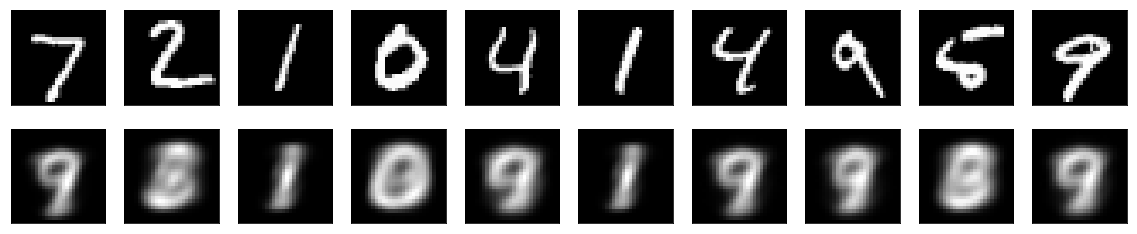

0.23700432


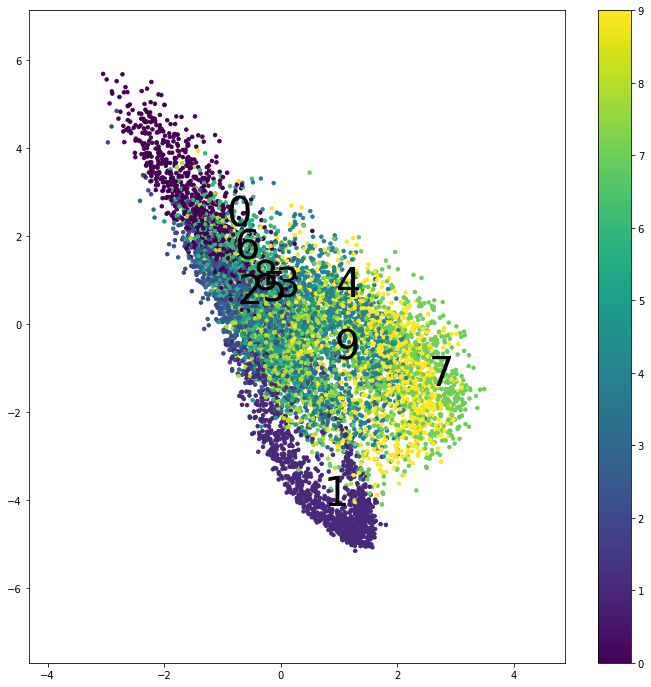

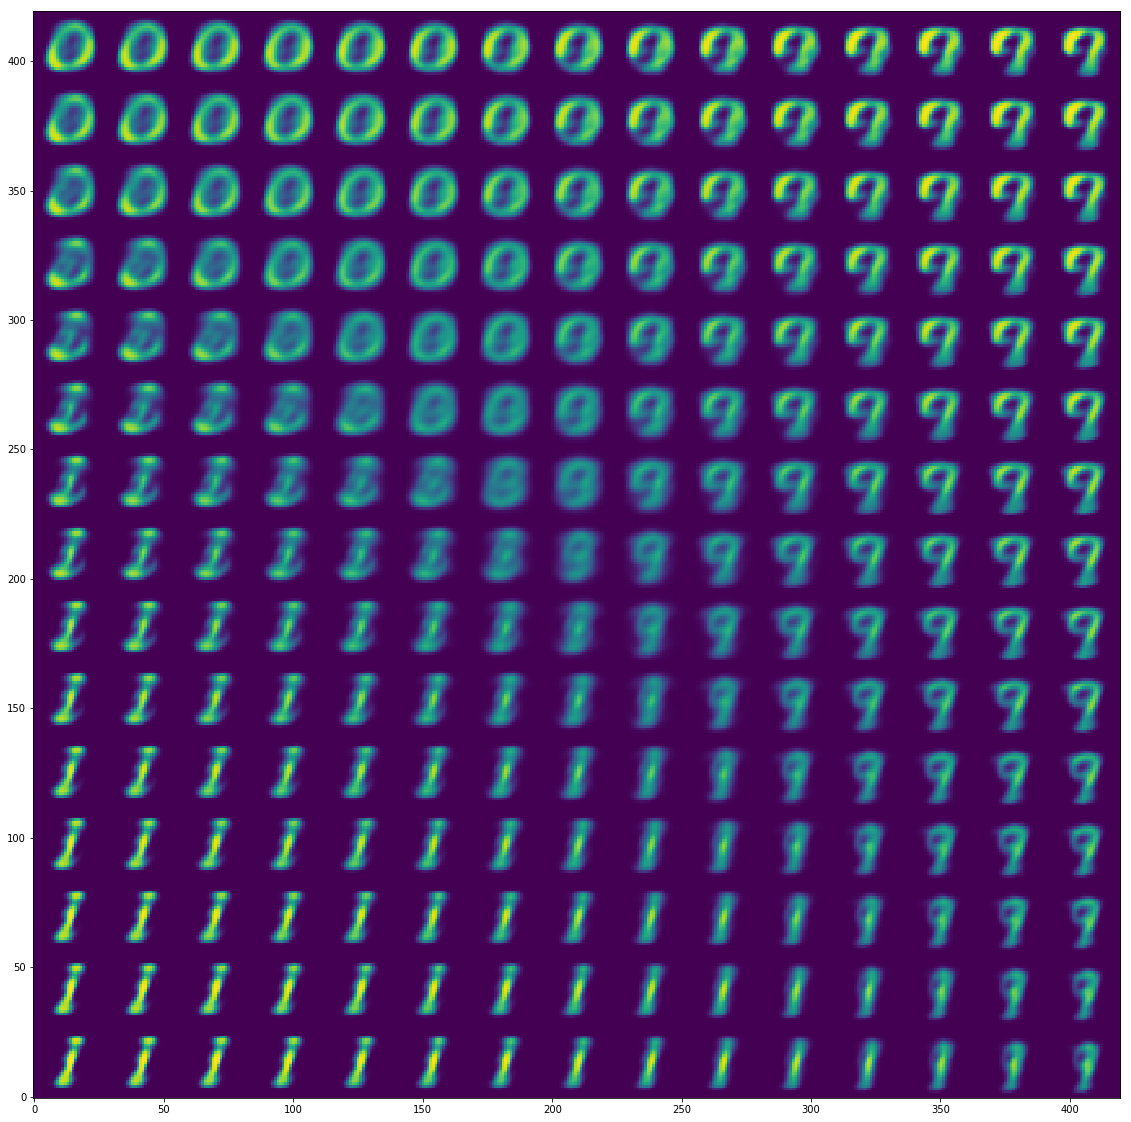

/opt/anaconda3/envs/py36/lib/python3.6/site-packages/keras/engine/saving.py:270: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                25120     
_________________________________________________________________
batch_normalization_15 (Batc (None, 32)                128       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 32)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 264       
_________________________________________________________________
batch_normalization_16 (Batc (None, 8)                 32        
__________

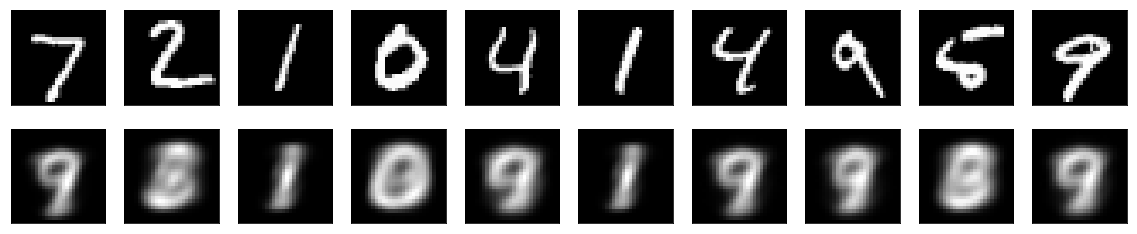

0.23700432
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 32)                25120     
_________________________________________________________________
batch_normalization_19 (Batc (None, 32)                128       
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 32)                0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 264       
_________________________________________________________________
batch_normalization_20 (Batc (None, 8)                 32        

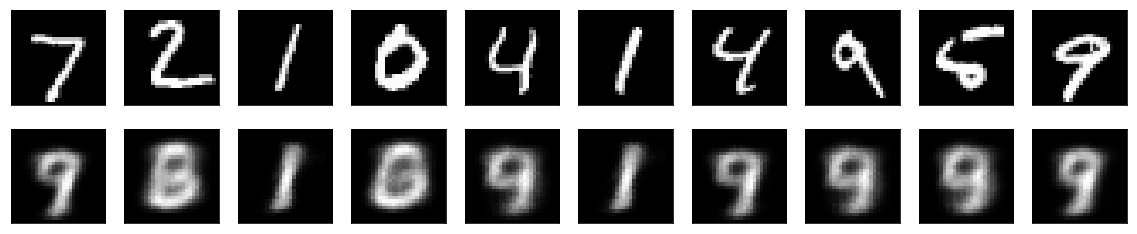

0.23016405


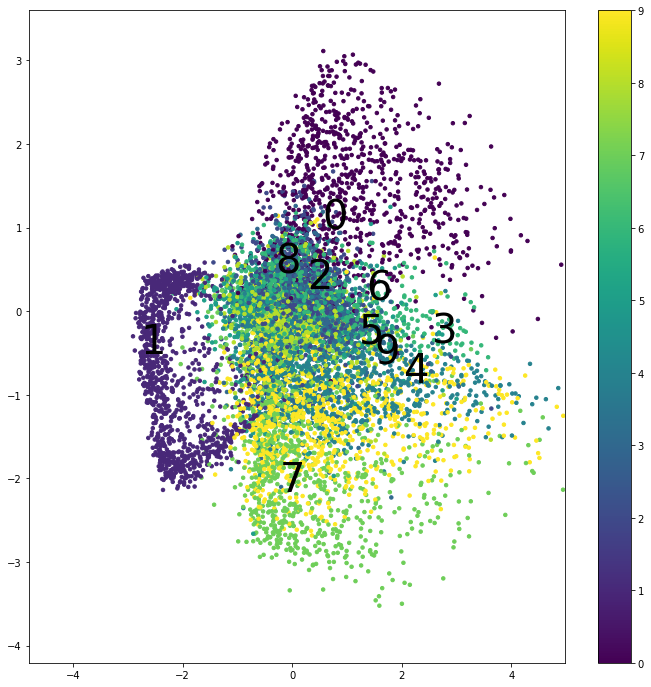

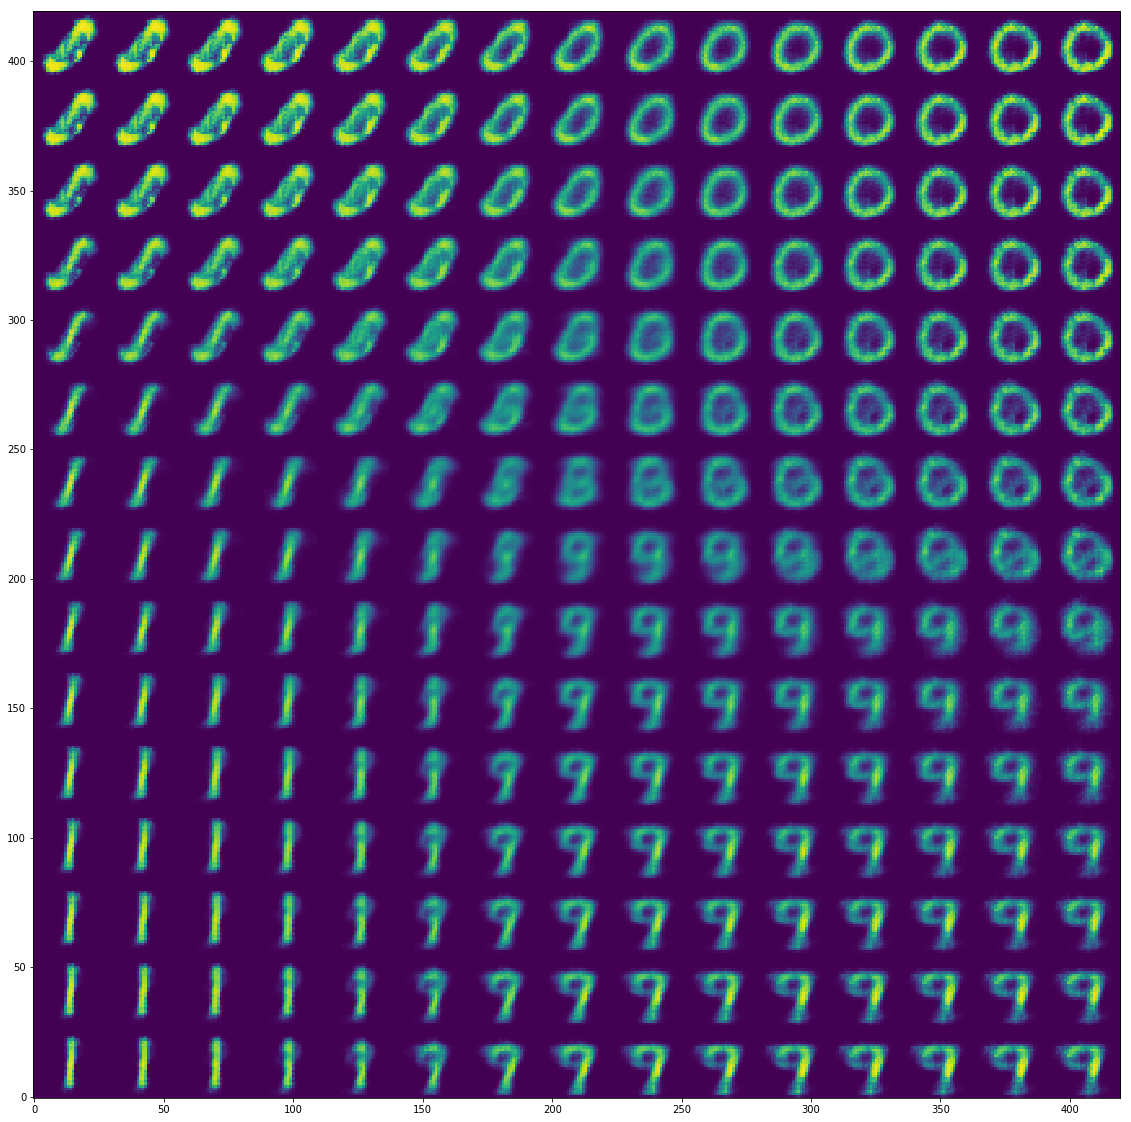

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 4)         40        
_________________________________________________________________
batch_normalization_24 (Batc (None, 14, 14, 4)         16        
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 14, 14, 4)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 16)          592       
_________________________________________________________________
batch_normalization_25 (Batc (None, 7, 7, 16)          64        
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 7, 7, 16)          0         
__________

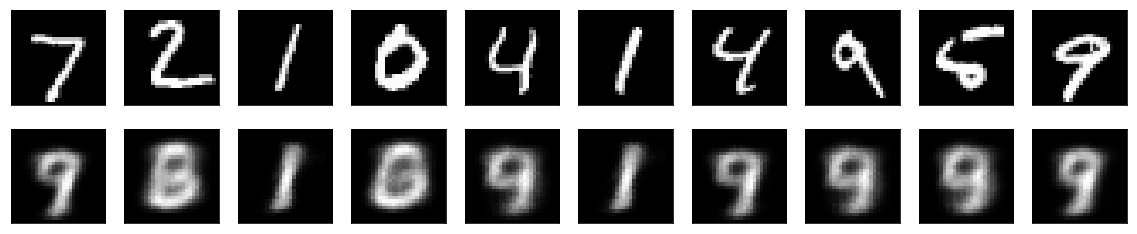

0.23016405
[1, 4, 16]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 8)         80        
_________________________________________________________________
batch_normalization_30 (Batc (None, 14, 14, 8)         32        
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 32)          2336      
_________________________________________________________________
batch_normalization_31 (Batc (None, 7, 7, 32)          128       
_________________________________________________________________
leaky_re_lu_31 (LeakyReLU)   (None, 7, 7, 32)         

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 124us/step - loss: 0.5425 - val_loss: 0.4683

Epoch 00001: val_loss improved from inf to 0.46830, saving model to ../model/temp//AutoEncoder1538371397.5467975.hdf5
Epoch 2/10
60000/60000 [==============================] - 2s 30us/step - loss: 0.3340 - val_loss: 0.3009

Epoch 00002: val_loss improved from 0.46830 to 0.30093, saving model to ../model/temp//AutoEncoder1538371397.5467975.hdf5
Epoch 3/10
60000/60000 [==============================] - 2s 29us/step - loss: 0.2853 - val_loss: 0.2616

Epoch 00003: val_loss improved from 0.30093 to 0.26159, saving model to ../model/temp//AutoEncoder1538371397.5467975.hdf5
Epoch 4/10
60000/60000 [==============================] - 2s 28us/step - loss: 0.2695 - val_loss: 0.2480

Epoch 00004: val_loss improved from 0.26159 to 0.24799, saving model to ../model/temp//AutoEncoder1538371397.5467975.hdf5
Epoch 5/10
60000/60000 [=================

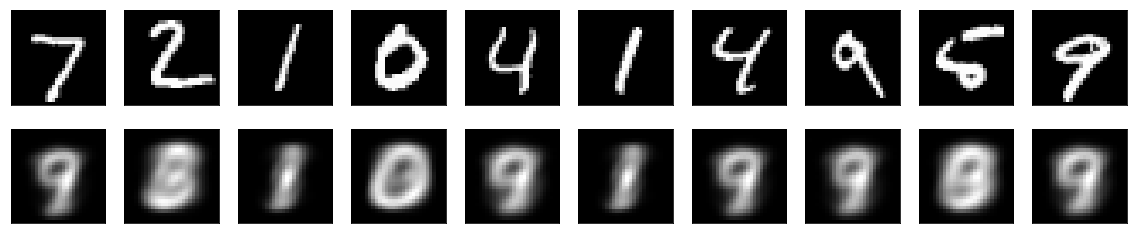

0.23851168


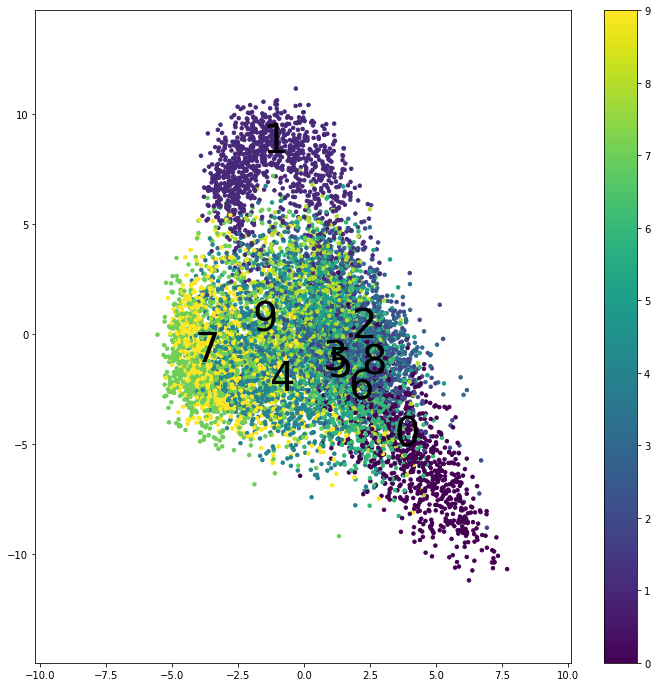

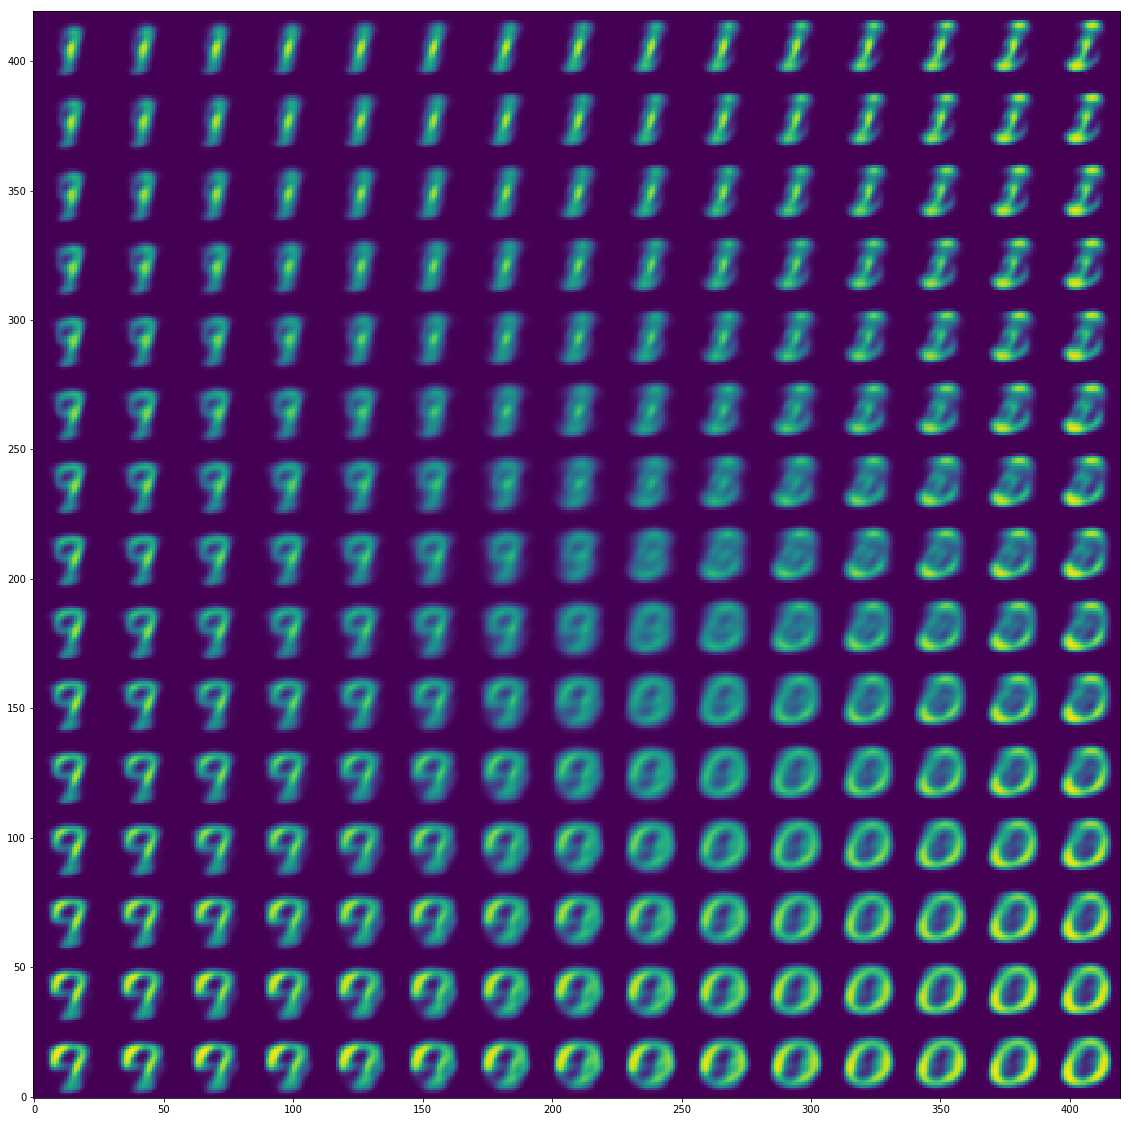

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_32 (Dense)                (None, 32)           25120       input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 32)           128         dense_32[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_38 (LeakyReLU)      (None, 32)           0           batch_normalization_38[0][0]     
__________________________________________________________________________________________________
dropout_22

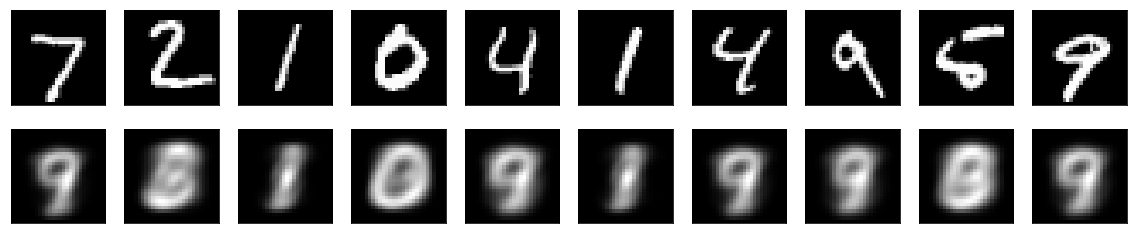

0.23852783
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 14, 14, 4)    40          input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_42 (BatchNo (None, 14, 14, 4)    16          conv2d_9[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_42 (LeakyReLU)      (None, 14, 14, 4)    0           batch_normalization_42[0][0]     
__________________________________________________________________________________________________

Epoch 8/10
60000/60000 [==============================] - 2s 36us/step - loss: 0.2346 - val_loss: 0.2220

Epoch 00008: val_loss improved from 0.22324 to 0.22200, saving model to ../model/temp//AutoEncoder1538371477.507642.hdf5
Epoch 9/10
60000/60000 [==============================] - 2s 35us/step - loss: 0.2336 - val_loss: 0.2227

Epoch 00009: val_loss did not improve from 0.22200
Epoch 10/10
60000/60000 [==============================] - 2s 34us/step - loss: 0.2325 - val_loss: 0.2211

Epoch 00010: val_loss improved from 0.22200 to 0.22109, saving model to ../model/temp//AutoEncoder1538371477.507642.hdf5


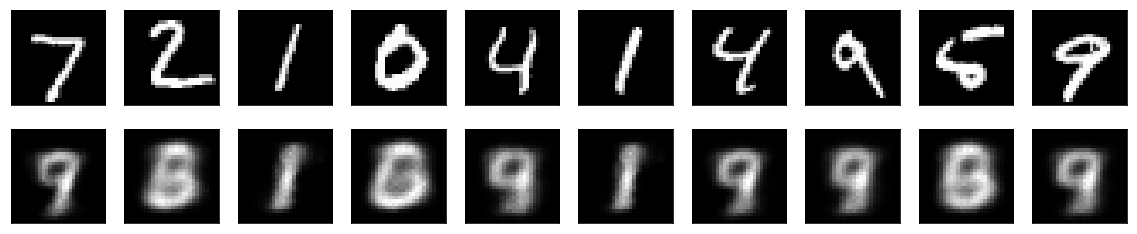

0.23297186


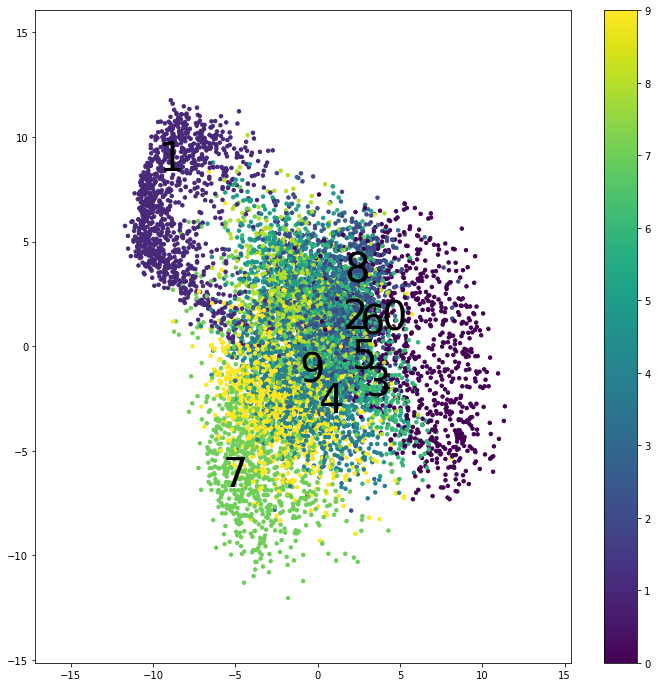

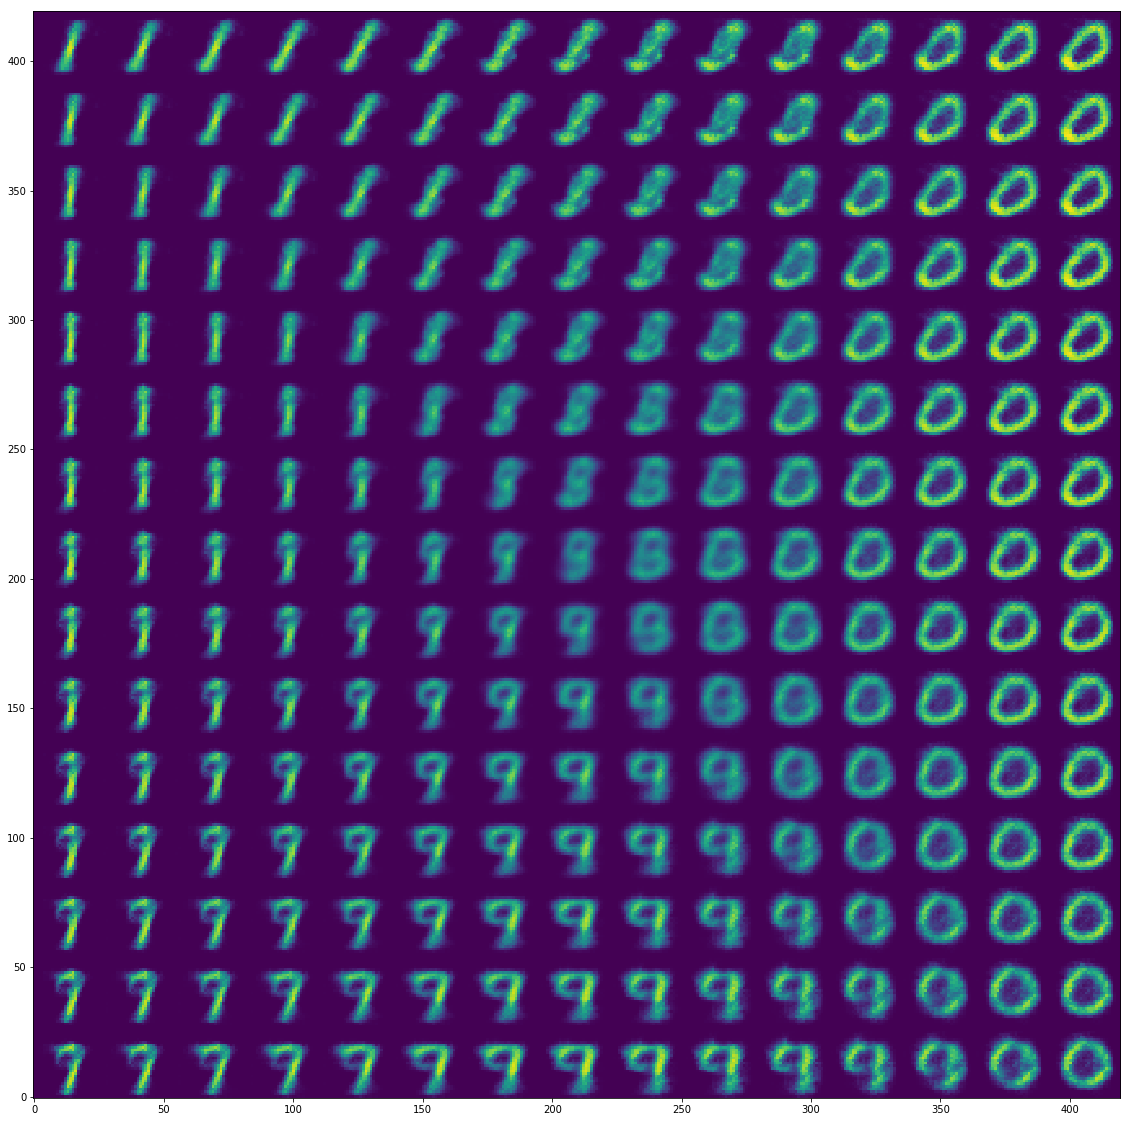

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 14, 14, 4)    40          input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_42 (BatchNo (None, 14, 14, 4)    16          conv2d_9[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_42 (LeakyReLU)      (None, 14, 14, 4)    0           batch_normalization_42[0][0]     
__________________________________________________________________________________________________
conv2d_10 

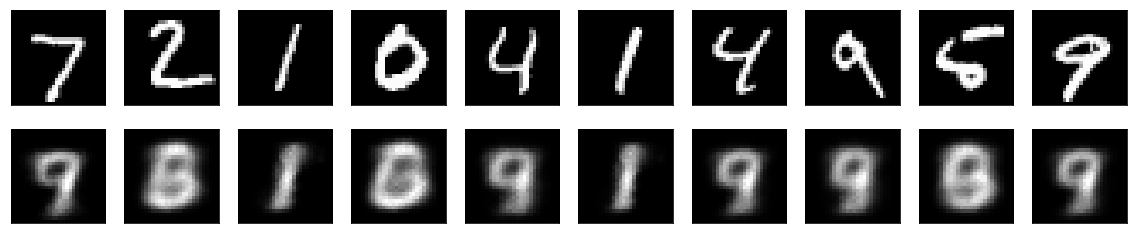

0.23297206


In [9]:
if __name__ == '__main__':
    testAE = TestAE()
    testAE.test_init()
    testAE.test_fit()
#     testAE.test_fit_check_best()
    testAE.test_prediction()
    testAE.test_save()
    testAE.test_load()
    testAE.test_specific_decode()
    
    testConvAE = TestConvAE()
    testConvAE.test_init()
    testConvAE.test_fit()
#     testConvAE.test_fit_check_best()
    testConvAE.test_prediction()
    testConvAE.test_save()
    testConvAE.test_load()
    testConvAE.test_specific_decode()
    
    testVAE = TestVAE()
    testVAE.test_init()
    testVAE.test_fit()
#     testVAE.test_fit_check_best()
    testVAE.test_prediction()
    testVAE.test_save()
    testVAE.test_load()
    
    testConv = TestConvVAE()
    testConv.test_init()
    testConv.test_fit()
    testConv.test_prediction()
    testConv.test_save()
    testConv.test_load()

In [7]:
# from keras.datasets import mnist
# import numpy as np
# numEpochs = 2
# sizeBatch = 128
# sizeKernel = 3
# layerDense = [16, 2]
# ratRecon = 1
# nameOptim = 'adam'
# modelPath = '../model/temp/'
# patience = 3
# stdEps = 1.0

# (xTrain, yTrain), (xTest, yTest) = mnist.load_data()
# xTrain = xTrain.astype('float32') / 255.
# xTest = xTest.astype('float32') / 255.
# numTrain = len(xTrain)
# numTest = len(xTest)
# sizeDigit = xTrain.shape[1:]

# dimInput = np.prod(xTrain.shape[1:])
# xTrain = xTrain.reshape((numTrain, dimInput))
# xTest = xTest.reshape((numTest, dimInput))
# print(xTrain.shape)
# print(xTest.shape)


# layerDense=[64, 2] 
# actDense='relu'
# ratRecon=0.998
# dimEncode = layerDense[-1]

# inputs = Input(shape=(dimInput,)) 
# x = inputs

# # Stack of Dense layers
# for numFilt in layerDense[:-1]:
#     x = Dense(numFilt, activation=actDense)(x)
# zMean = Dense(dimEncode)(x)
# zSigmaLog = Dense(dimEncode)(x) # log for linear dense

# def sampling(args):
#     zMean, zSigmaLog = args
#     epsilon = K.random_normal(shape=(K.shape(zMean)[0], K.shape(zMean)[1]),
#                               mean=0., stddev=stdEps)
#     return zMean + K.exp(zSigmaLog) * epsilon  
    
# # Construct the latent as the output and build the encorder pipeline
# z = Lambda(sampling)([zMean, zSigmaLog])
# encoder = Model(inputs, z, name='encoder')

# # Build the Decoder Model
# inputLatent = Input(shape=(dimEncode,), name='decoder_input')
# x = inputLatent
# for numFilt in layerDense[-2::-1]:
#     x = Dense(numFilt, activation=actDense)(x)

# # Reconstruct the pixels as the output and build the decorder pipeline
# outputs = Dense(dimInput, activation='sigmoid', name='decoder_output')(x)
# decoder = Model(inputLatent, outputs, name='decoder')

# autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')

# def lossVAE(tensorInput, tensorDecode):
#     zMean = zMean
#     zSigmaLog = zSigmaLog
#     ratRecon = ratRecon

#     lossRecon =  metrics.binary_crossentropy(K.flatten(tensorInput), K.flatten(tensorDecode))
# #         lossRecon =  metrics.mean_squared_error(K.flatten(tensorInput), K.flatten(tensorDecode))
#     lossKL = - 0.5 * K.sum(1 + 2 * zSigmaLog - K.square(zMean) - K.square(K.exp(zSigmaLog)), axis=-1)
#     return ratRecon * lossRecon + (1 - ratRecon) * lossKL

# autoencoder.compile(optimizer=nameOptim, loss=lossVAE)

# history = autoencoder.fit(xTrain, xTrain,
#                           epochs=numEpochs,
#                           batch_size=sizeBatch, shuffle=True,
#                           callbacks=callbacks,
#                           validation_data=(xValid, xValid)
#                          )
# vae.encoder.save('./encoder.h5')